In [3]:
!pip install spacy
!python -m spacy download en_core_web_sm

You should consider upgrading via the '/root/.pyenv/versions/3.8.16/envs/cdp/bin/python3.8 -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.2 MB/s eta 0:00:0000:010:01


You should consider upgrading via the '/root/.pyenv/versions/cdp/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [150]:
import numpy as np
import pandas as pd
import spacy

import matplotlib.pyplot as plt

In [66]:
text = "Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. "
# text = "As a result, Salman’s account reached $2.1 million."

In [67]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

Finally finally ADV RB advmod Xxxxx True False
, , PUNCT , punct , False False
that that DET DT det xxxx True True
court court NOUN NN nsubj xxxx True False
held hold VERB VBD ROOT xxxx True False
that that SCONJ IN mark xxxx True True
the the DET DT det xxx True True
First First PROPN NNP compound Xxxxx True True
Amendment Amendment PROPN NNP nsubj Xxxxx True False
protects protect VERB VBZ ccomp xxxx True False
uninhibited uninhibited ADJ JJ amod xxxx True False
, , PUNCT , punct , False False
robust robust ADJ JJ amod xxxx True False
debate debate NOUN NN dobj xxxx True False
, , PUNCT , punct , False False
rather rather ADV RB advmod xxxx True True
than than ADP IN cc xxxx True True
an an DET DT det xx True True
open open ADJ JJ amod xxxx True False
season season NOUN NN conj xxxx True False
to to PART TO aux xx True True
shoot shoot VERB VB relcl xxxx True False
down down ADP RP prt xxxx True True
the the DET DT det xxx True True
good good ADJ JJ amod xxxx True False
name name NOU

In [116]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.render(doc, style='dep')

In [42]:
def pfacts(facts):
    sentences = nlp(facts).sents
    for s in sentences:
        print(s.text, end='\n\n')

In [70]:
train_data = pd.read_csv("../../data/open/train.csv")
train_data

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1
...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0


In [142]:
from tqdm import tqdm

def compute_importance(docs):
    transition_words = ["accordingly", "additionally", "also", "although", "alternatively", "as a result", "besides", "but", "consequently", "conversely", "despite", "due to", "either", "equally", "eventually", "finally", "first", "furthermore", "hence", "however", "in addition", "in conclusion", "in contrast", "in other words", "in spite of", "instead", "likewise", "meanwhile", "moreover", "nevertheless", "next", "nonetheless", "nor", "on the contrary", "on the other hand", "otherwise", "overall", "particularly", "similarly", "since", "so", "subsequently", "that is", "then", "therefore", "though", "thus", "ultimately", "unless", "unlike", "until", "when", "whereas", "while", "yet", "above all", "afterward", "all in all", "as an illustration", "as well as", "at the same time", "at length", "basically", "certainly", "comparatively", "consequently", "eventually", "for example", "for instance", "for this reason", "for the most part", "for this purpose", "generally", "given these points", "in a word", "in any case", "in essence", "in fact", "in general", "in particular", "in reality", "in short", "in summary", "in the first place", "notably", "of course", "of great importance", "of necessity", "of course", "of great importance", "of necessity", "specifically", "surprisingly", "to begin with", "to conclude", "to illustrate", "to sum up", "to summarize", "truly", "without a doubt"]
    core_words       = ['court', 'reverse', 'judge', 'adjudicate', 'guilty']
    
    result = pd.DataFrame(columns=['sentence', 'doc_id', 'is_selected'])
    for doc_id, doc in tqdm(list(enumerate(docs))):
        for sent in nlp(doc).sents:
            sent_str = sent.text
            cond1 = any(sent_str.lower().startswith(word) for word in transition_words)
            cond2 = any(word in sent.lemma_.lower() for word in core_words)
            is_selected = True if any([cond1, cond2]) else False
            result.loc[len(result)] = [sent_str, doc_id, is_selected]
        result.loc[len(result)-1, 'is_selected'] = True
    return result

docs = train_data.facts
df_imp = compute_importance(docs)
df_imp

100%|██████████| 2478/2478 [00:46<00:00, 53.44it/s]


,sentence,doc_id,is_selected
0,"On June 27, 1962, Phil St. Amant, a candidate ...",0,False
1,"During this speech, St. Amant accused his poli...",0,False
2,"Finally, St. Amant implicated Herman Thompson,...",0,True
3,Thompson successfully sued St. Amant for defam...,0,False
4,Louisiana’s First Circuit Court of Appeals rev...,0,True
...,...,...,...
18634,"According to the patent's claim, the portion o...",2477,False
18635,"Westview Instruments, Inc.'s product also uses...",2477,False
18636,"In an infringement suit, after hearing an expe...",2477,False
18637,"However, the District Court directed a verdict...",2477,True


- 너무 많이 선택된 느낌

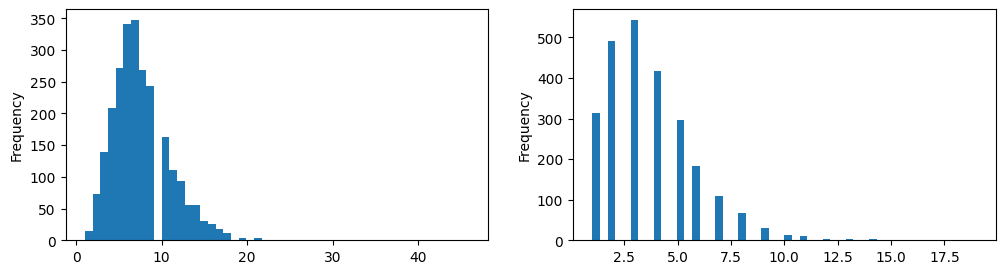

In [152]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
df_imp.groupby('doc_id')['is_selected'].size().plot.hist(bins=50, ax=ax1)
df_imp.groupby('doc_id')['is_selected'].sum().plot.hist(bins=50, ax=ax2);

In [160]:
def select_sentences(data):
    transition_words = ["accordingly", "additionally", "also", "although", "alternatively", "as a result", "besides", "but", "consequently", "conversely", "despite", "due to", "either", "equally", "eventually", "finally", "first", "furthermore", "hence", "however", "in addition", "in conclusion", "in contrast", "in other words", "in spite of", "instead", "likewise", "meanwhile", "moreover", "nevertheless", "next", "nonetheless", "nor", "on the contrary", "on the other hand", "otherwise", "overall", "particularly", "similarly", "since", "so", "subsequently", "that is", "then", "therefore", "though", "thus", "ultimately", "unless", "unlike", "until", "when", "whereas", "while", "yet", "above all", "afterward", "all in all", "as an illustration", "as well as", "at the same time", "at length", "basically", "certainly", "comparatively", "consequently", "eventually", "for example", "for instance", "for this reason", "for the most part", "for this purpose", "generally", "given these points", "in a word", "in any case", "in essence", "in fact", "in general", "in particular", "in reality", "in short", "in summary", "in the first place", "notably", "of course", "of great importance", "of necessity", "of course", "of great importance", "of necessity", "specifically", "surprisingly", "to begin with", "to conclude", "to illustrate", "to sum up", "to summarize", "truly", "without a doubt"]
    core_words       = ['court', 'reverse', 'judge', 'adjudicate', 'guilty']
    
    data = data.reset_index(drop=True)
    docs = data.facts
    
    result = pd.DataFrame(columns=['sentence', 'doc_id', 'is_selected'])
    for doc_id, doc in tqdm(list(enumerate(docs))):
        selected_sents = []
        for sent in nlp(doc).sents:
            sent_str = sent.text
            cond1 = any(sent_str.lower().startswith(word) for word in transition_words)
            cond2 = any(word in sent.lemma_.lower() for word in core_words)
            is_selected = True if any([cond1, cond2]) else False
            if is_selected:
                selected_sents.append(sent_str)
        data.loc[doc_id, 'facts'] = ' '.join(selected_sents)
    return data

In [161]:
train_data_pp = select_sentences(train_data)

100%|██████████| 2478/2478 [00:35<00:00, 70.47it/s]


In [167]:
train_data.facts.str.len().mean()

1109.0564971751412

In [168]:
train_data_pp.facts.str.len().mean()

533.0960451977401